# Part 1 Data Bias and Quality Assessment
## Data pre-processing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.core.display import HTML
warnings.filterwarnings("ignore", message="iteritems is deprecated and will be removed in a future version. Use .items instead.", category=FutureWarning)

# Reading the internal and external data
internal_data = pd.read_csv('internal.csv')
external_data = pd.read_csv('external.csv')

# Data Pre-Processing, Comparison and Alignment:
#  Ensure that the time frames for the external dataset and your internal ground truth align
# Convert the date columns to datetime objects for easier manipulation
external_data['date_order'] = pd.to_datetime(external_data['date_order'])
internal_data['week'] = pd.to_datetime(internal_data['week'])
internal_data = internal_data.drop('country_name', axis=1)

# Extract the date range for both datasets
external_date_range = (external_data['date_order'].min(), external_data['date_order'].max())
internal_date_range = (internal_data['week'].min(), internal_data['week'].max())

# Making sure that the internal data set allways starts with the monday and that th  week increments remain to be 7 days
#Creating a dictionary to map each original date to a new date incremented by 7 days
unique_dates_week = sorted(internal_data['week'].unique())
week_date_mapping = {}
current_week_date = unique_dates_week[0]
for original_week_date in unique_dates_week:
    week_date_mapping[original_week_date] = current_week_date
    current_week_date += pd.Timedelta(days=7)
internal_data['week'] = internal_data['week'].map(week_date_mapping)

# Aggregate the external dataset to weekly
# We'll use the date_order column to group the data by week
external_data_weekly = external_data.groupby([pd.Grouper(key='date_order', freq='W-Mon'), 'city_name', 'competitor']).agg(
    orders=pd.NamedAgg(column='date_order', aggfunc='count'),
    billings=pd.NamedAgg(column='billings', aggfunc='sum'),
    subtotal=pd.NamedAgg(column='subtotal', aggfunc='sum'),
    delivery_fees=pd.NamedAgg(column='delivery_fees', aggfunc='sum'),
    service_fees=pd.NamedAgg(column='service_fees', aggfunc='sum'),
    other_fees=pd.NamedAgg(column='other_fees', aggfunc='sum'),
    promotions=pd.NamedAgg(column='promotions', aggfunc='sum')
).reset_index()
external_data_weekly.rename(columns={'date_order': 'week'}, inplace=True)
external_data_weekly['week'] = pd.to_datetime(external_data_weekly['week'])

# match the date range of the internal dataset to the external one
external_data_weekly = external_data_weekly[
    (external_data_weekly['week'] >= internal_date_range[0]) &
    (external_data_weekly['week'] <= internal_date_range[1])]

#Check if the geographical coverage is similar comparing the unique combinations of cities in both datasets
external_geo_coverage = external_data[['city_name']].drop_duplicates().sort_values(by=['city_name'])
internal_geo_coverage = internal_data[['city_name']].drop_duplicates().sort_values(by=['city_name'])
external_data_weekly = external_data_weekly[external_data_weekly['city_name'] != 'missing_city']

#aggregating the 'other' cities duplicates in the internal dataset into 1 per week
other_city_data = internal_data[internal_data['city_name'] == 'other']
other_data_grouped = other_city_data.groupby('week').sum().reset_index()
other_data_grouped['city_name'] = 'other'
internal_data = internal_data[internal_data['city_name'] != 'other']
internal_data = internal_data.append(other_data_grouped, ignore_index=True)

/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/1384715725.py:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  other_data_grouped = other_city_data.groupby('week').sum().reset_index()
/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/1384715725.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  internal_data = internal_data.append(other_data_grouped, ignore_index=True)


## Descriptive Data Analysis for finding bias

In [2]:
# Calculating descriptive statistics for the external weekly dataset
external_weekly_stats = external_data_weekly.describe()
internal_data_stats = internal_data.describe()

# Splitting the external dataset into subsets based on the competitor for comparison
external_Internal_org = external_data_weekly[external_data_weekly['competitor'] == 'Internal_org'].reset_index(drop=True)
external_Competitor_A = external_data_weekly[external_data_weekly['competitor'] == 'Competitor_A']
external_Competitor_B = external_data_weekly[external_data_weekly['competitor'] == 'Competitor_B']

# Calculating descriptive statistics for each competitor
stats_external_Internal_org = external_Internal_org.describe()
stats_Competitor_A = external_Competitor_A.describe()
stats_Competitor_B = external_Competitor_B.describe()

In [3]:
internal_data_stats

orders      billings      subtotal  delivery_fees  service_fees  \
count  2.768000e+03  2.768000e+03  2.768000e+03   2.768000e+03  2.768000e+03   
mean   1.334158e+05  4.569407e+08  3.753551e+08   7.376047e+07  1.398739e+07   
std    2.905266e+05  1.035998e+09  8.601374e+08   1.460767e+08  5.378553e+07   
min    9.630000e+02  2.832353e+06  2.214841e+06   6.160245e+05  0.000000e+00   
25%    1.465725e+04  4.319310e+07  3.427001e+07   9.336479e+06  0.000000e+00   
50%    3.864800e+04  1.195575e+08  9.499748e+07   2.608395e+07  0.000000e+00   
75%    1.161870e+05  4.066545e+08  3.337823e+08   6.780066e+07  1.044402e+07   
max    2.267263e+06  8.635200e+09  7.291989e+09   9.218634e+08  4.949896e+08   

         other_fees    promotions  
count  2.768000e+03  2.768000e+03  
mean   2.473635e+05 -3.429568e+07  
std    1.014873e+06  8.665797e+07  
min    0.000000e+00 -8.896548e+08  
25%    0.000000e+00 -3.363115e+07  
50%    0.000000e+00 -4.751931e+06  
75%    1.052415e+05 -3.110712e+05  
max    1.556291e+07 -2.730000e+03

In [4]:
stats_external_Internal_org

orders      billings      subtotal  delivery_fees  service_fees  \
count   2691.000000  2.691000e+03  2.691000e+03   2.691000e+03  2.691000e+03   
mean     611.110368  2.817100e+06  2.381640e+06   4.355696e+05  1.067878e+05   
std     1480.387107  6.987453e+06  5.959945e+06   9.604681e+05  4.147296e+05   
min        1.000000  3.931200e+03  1.638000e+03   9.555000e+02  0.000000e+00   
25%       50.000000  2.198469e+05  1.696422e+05   4.340700e+04  0.000000e+00   
50%      149.000000  6.625710e+05  5.274633e+05   1.254435e+05  0.000000e+00   
75%      542.000000  2.499274e+06  2.184382e+06   3.950447e+05  6.448260e+04   
max    15695.000000  7.803809e+07  6.727001e+07   9.526253e+06  5.110860e+06   

         other_fees    promotions  
count  2.691000e+03  2.691000e+03  
mean   1.649729e+05 -2.709051e+05  
std    4.153296e+05  7.162508e+05  
min    0.000000e+00 -9.239467e+06  
25%    1.042860e+04 -2.584764e+05  
50%    3.306030e+04 -3.057600e+04  
75%    1.367184e+05 -1.365000e+03  
max    6.165132e+06  0.000000e+00

In [5]:
# Calculating variance and mean for each component in both datasets
variance_summary = {}
mean_summary = {}
components = ['billings', 'delivery_fees', 'service_fees', 'other_fees', 'promotions', 'subtotal']

for component in components:
    variance_internal = internal_data[component].var()
    variance_external = external_Internal_org[component].var()
    variance_summary[component] = {
        'Internal Variance': variance_internal,
        'External Variance': variance_external
    }
    mean_internal = internal_data[component].mean()
    mean_external = external_Internal_org[component].mean()
    mean_summary[component] = {
        'Internal Mean': mean_internal,
        'External Mean': mean_external
    }
variance_df = pd.DataFrame(variance_summary)
mean_df = pd.DataFrame(mean_summary)

## Visual Analysis for finding bias

/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/4070731194.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  internal_weekly_avg = internal_data.groupby('week').mean()['billings_per_order']
/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/4070731194.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  external_Internal_org_weekly_avg = external_Internal_org.groupby('week').mean()['billings_per_order']


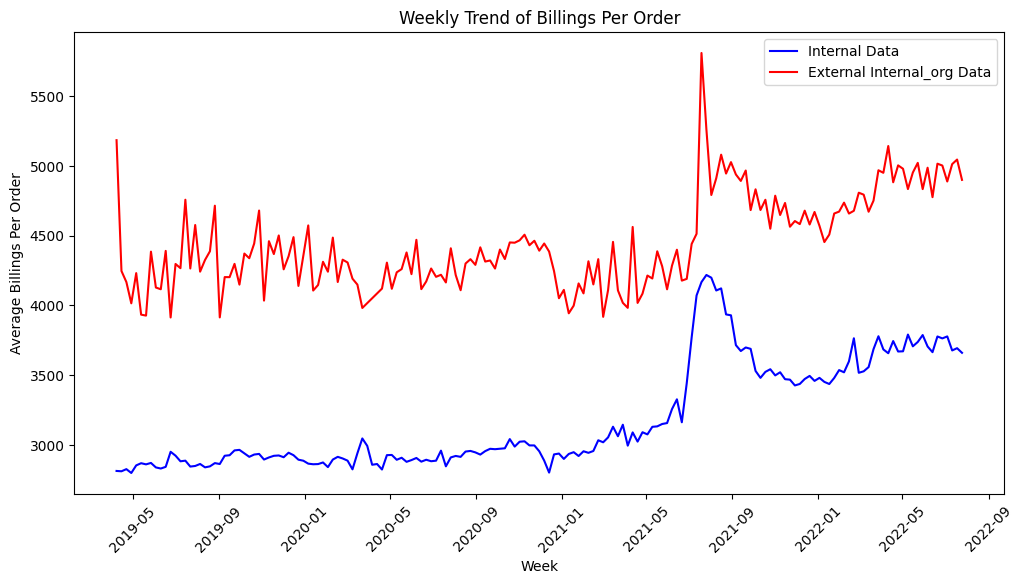

In [6]:
"""
A assumption in my analysis is that the bias present in the external dataset is 
consistent across competitors, so I will adjust bias with the same degree for UE as for the competition
This might cause overfitting

Another assumption I do regarding the data is that the sample size is consistent 
across competitors in the external dataset and is representive for all players. 
"""

# billings per order internal VS external
internal_data['billings_per_order'] = internal_data['billings'] / internal_data['orders']
external_Internal_org['billings_per_order'] = external_Internal_org['billings'] / external_Internal_org['orders']

# Aggregating data by week
internal_weekly_avg = internal_data.groupby('week').mean()['billings_per_order']
external_Internal_org_weekly_avg = external_Internal_org.groupby('week').mean()['billings_per_order']

# Creating the trend line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=internal_weekly_avg, label='Internal Data', color='blue')
sns.lineplot(data=external_Internal_org_weekly_avg, label='External Internal_org Data', color='red')
plt.title('Weekly Trend of Billings Per Order')
plt.xlabel('Week')
plt.ylabel('Average Billings Per Order')
plt.xticks(rotation=45)
plt.legend()
plt.show()

/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3522588527.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  external_weekly_city_avg = external_Internal_org.groupby(['week', 'city_name']).mean()['billings_per_order'].reset_index()


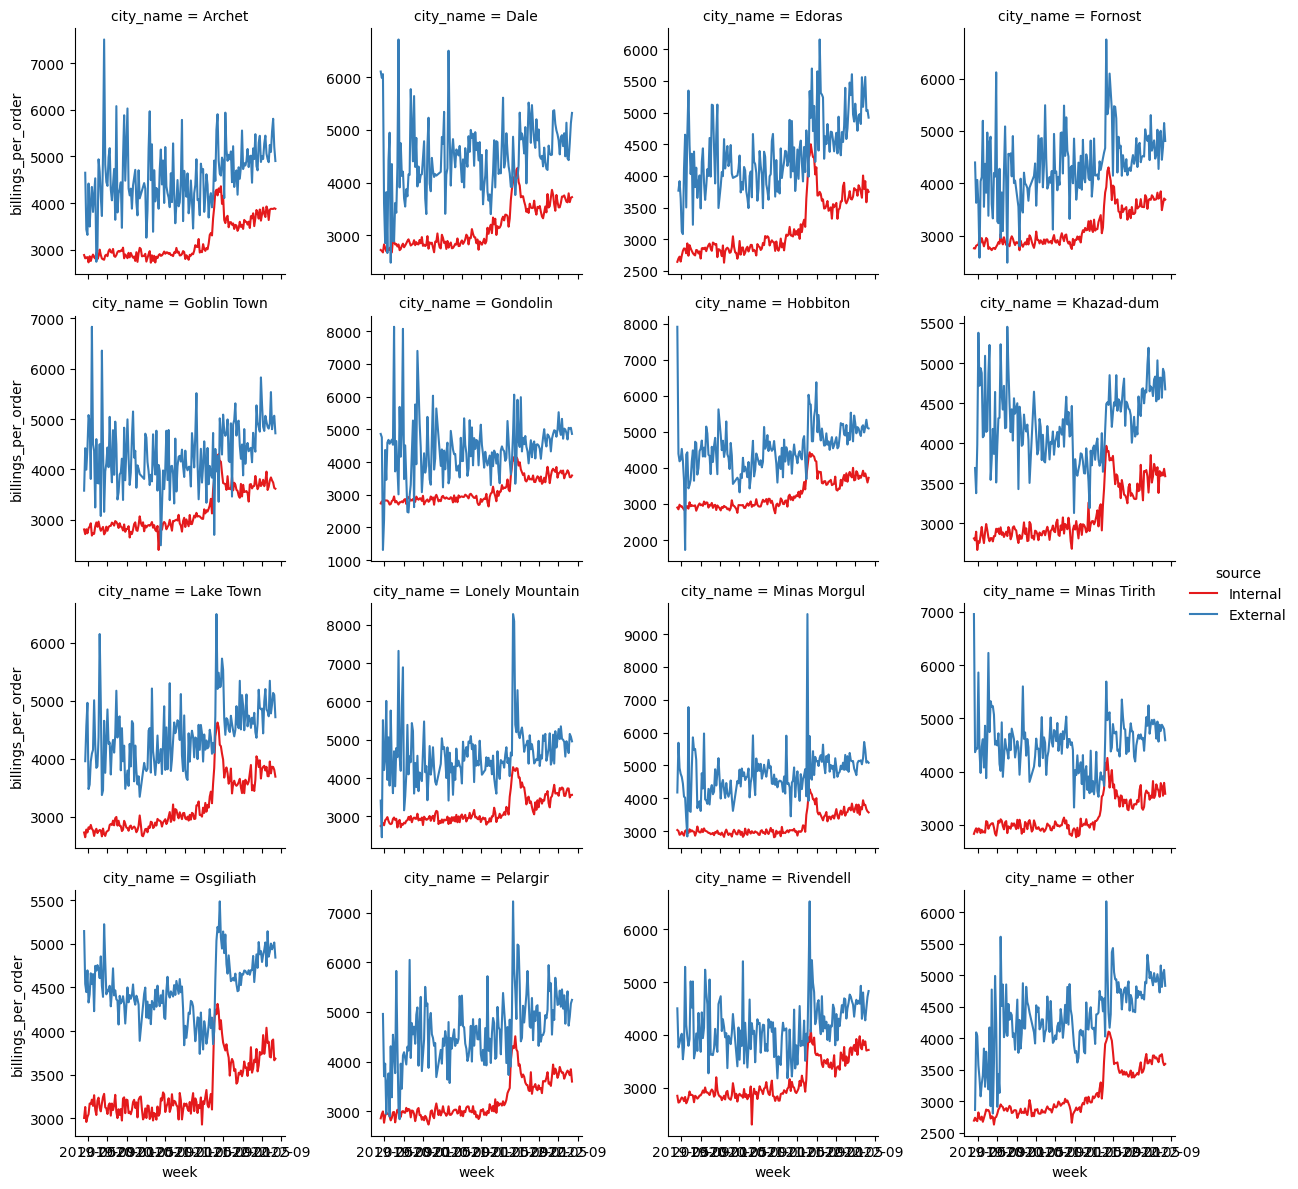

In [7]:
internal_data['billings_per_order'] = internal_data['billings'] / internal_data['orders']
internal_weekly_city_avg = internal_data.groupby(['week', 'city_name']).mean()['billings_per_order'].reset_index()
external_Internal_org['billings_per_order'] = external_Internal_org['billings'] / external_Internal_org['orders']
external_weekly_city_avg = external_Internal_org.groupby(['week', 'city_name']).mean()['billings_per_order'].reset_index()
# Merging the internal and external datasets for FacetGrid plotting
# We'll add a 'source' column to distinguish between the two datasets
internal_weekly_city_avg['source'] = 'Internal'
external_weekly_city_avg['source'] = 'External'
# Aligning the columns for merging
external_weekly_city_avg.rename(columns={'date_order': 'week'}, inplace=True)
# Concatenating the datasets
combined_data = pd.concat([internal_weekly_city_avg, external_weekly_city_avg])
# Creating a FacetGrid with Seaborn for all cities with both internal and external data lines
g = sns.FacetGrid(combined_data, col='city_name', col_wrap=4, hue='source', height=3, sharey=False, palette='Set1')
g.map(sns.lineplot, 'week', 'billings_per_order')
g.add_legend()
plt.show()

/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/1470420606.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  external_weekly_city_avg = external_Internal_org.groupby(['week', 'city_name']).mean()['promotions_per_order'].reset_index()


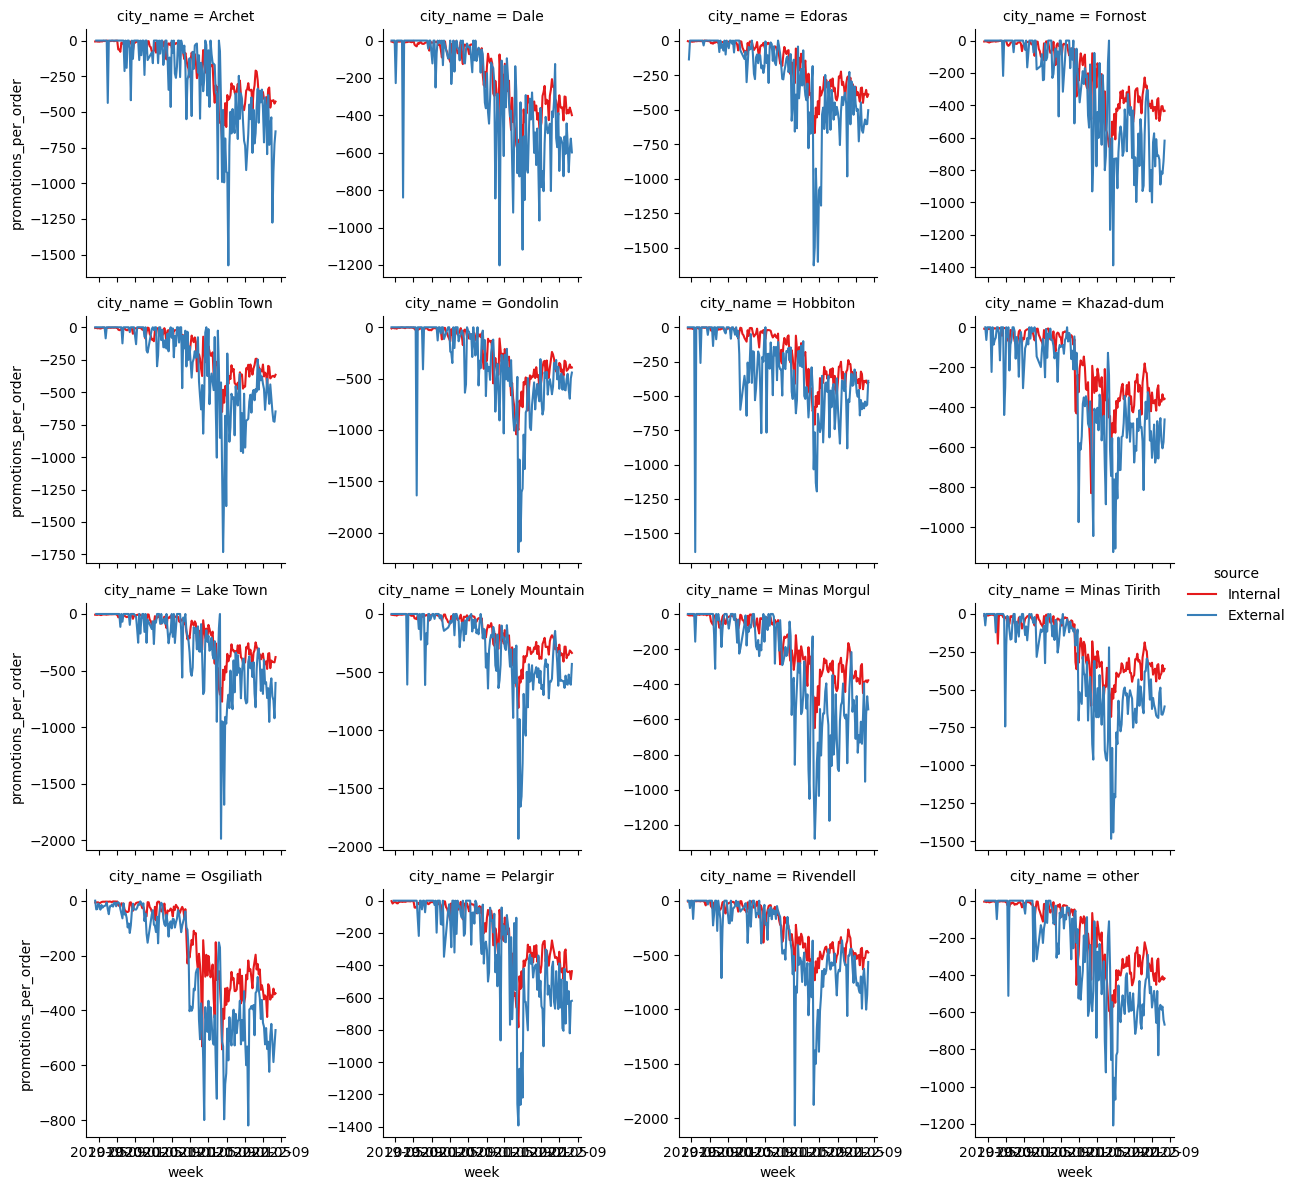

In [8]:
internal_data['promotions_per_order'] = internal_data['promotions'] / internal_data['orders']
internal_weekly_city_avg = internal_data.groupby(['week', 'city_name']).mean()['promotions_per_order'].reset_index()
external_Internal_org['promotions_per_order'] = external_Internal_org['promotions'] / external_Internal_org['orders']
external_weekly_city_avg = external_Internal_org.groupby(['week', 'city_name']).mean()['promotions_per_order'].reset_index()
# Merging the internal and external datasets for FacetGrid plotting & add a 'source' column to distinguish between the two datasets
internal_weekly_city_avg['source'] = 'Internal'
external_weekly_city_avg['source'] = 'External'
# Aligning the columns for merging
external_weekly_city_avg.rename(columns={'date_order': 'week'}, inplace=True)
# Concatenating the datasets
combined_data = pd.concat([internal_weekly_city_avg, external_weekly_city_avg])
# Creating a FacetGrid with Seaborn for all cities with both internal and external data lines
g = sns.FacetGrid(combined_data, col='city_name', col_wrap=4, hue='source', height=3, sharey=False, palette='Set1')
g.map(sns.lineplot, 'week', 'promotions_per_order')
g.add_legend()
plt.show()

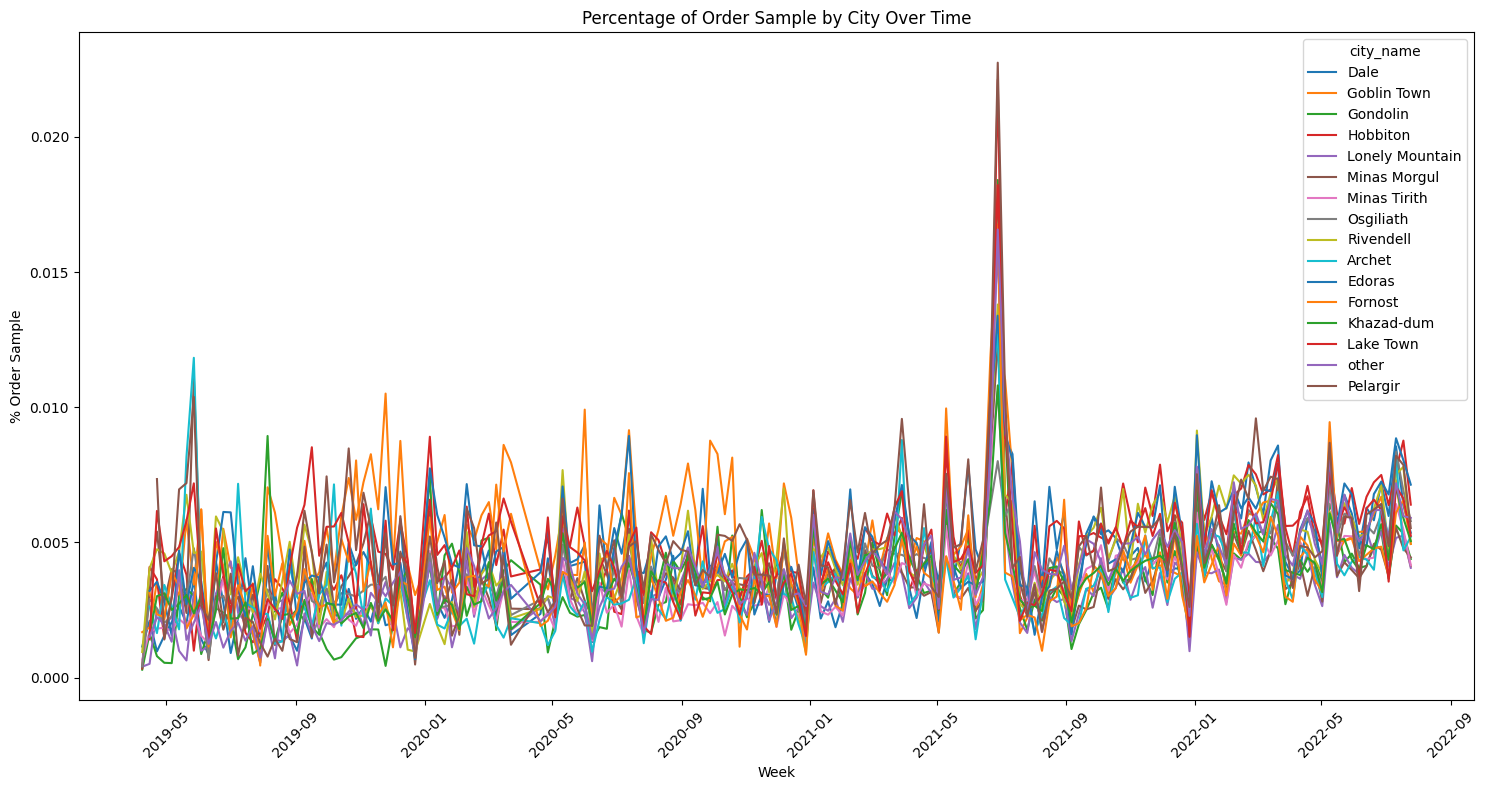

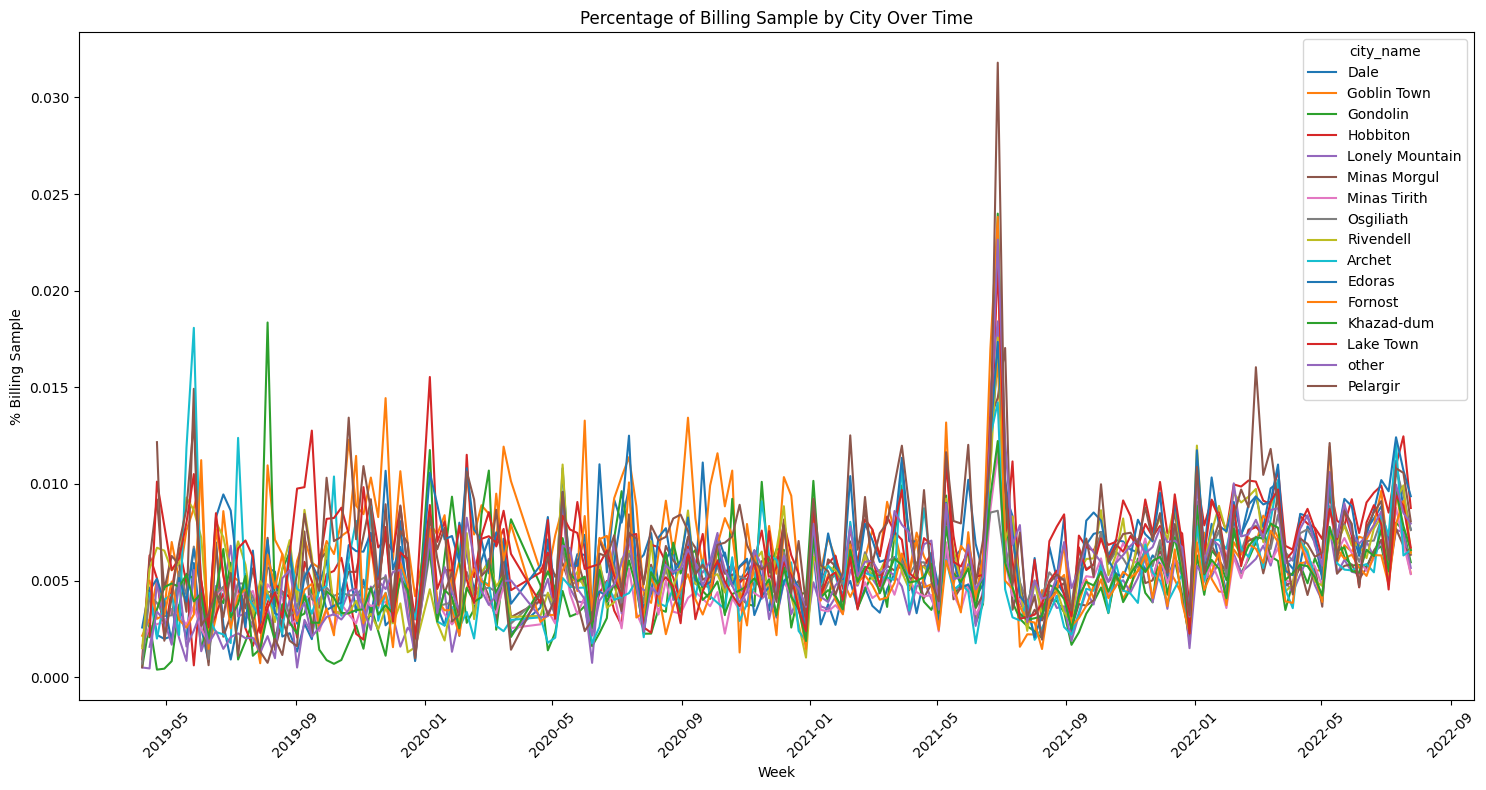

In [9]:
internal_data_renamed = internal_data.rename(columns={'orders': 'total_actual_orders','billings':'actual_billinigs'})
combined_data = pd.merge(external_Internal_org, internal_data_renamed[['week', 'city_name', 'total_actual_orders','actual_billinigs']], on=['week', 'city_name'])
combined_data['%_order_sample'] = combined_data['orders'] / combined_data['total_actual_orders']
combined_data['%_billing_sample'] = combined_data['billings'] / combined_data['actual_billinigs']
# Creating a FacetGrid with week on the x-axis and %_order_sample on the y-axis for each city
plt.figure(figsize=(15, 8))
sns.lineplot(data=combined_data, x="week", y="%_order_sample", hue="city_name", palette="tab10")
plt.xticks(rotation=45)
plt.xlabel("Week")
plt.ylabel("% Order Sample")
plt.title("Percentage of Order Sample by City Over Time")
plt.tight_layout()
plt.show()
# Creating a FacetGrid with week on the x-axis and %_billing_sample on the y-axis for each city
plt.figure(figsize=(15, 8))
sns.lineplot(data=combined_data, x="week", y="%_billing_sample", hue="city_name", palette="tab10")
plt.xticks(rotation=45)
plt.xlabel("Week")
plt.ylabel("% Billing Sample")
plt.title("Percentage of Billing Sample by City Over Time")
plt.tight_layout()
plt.show()

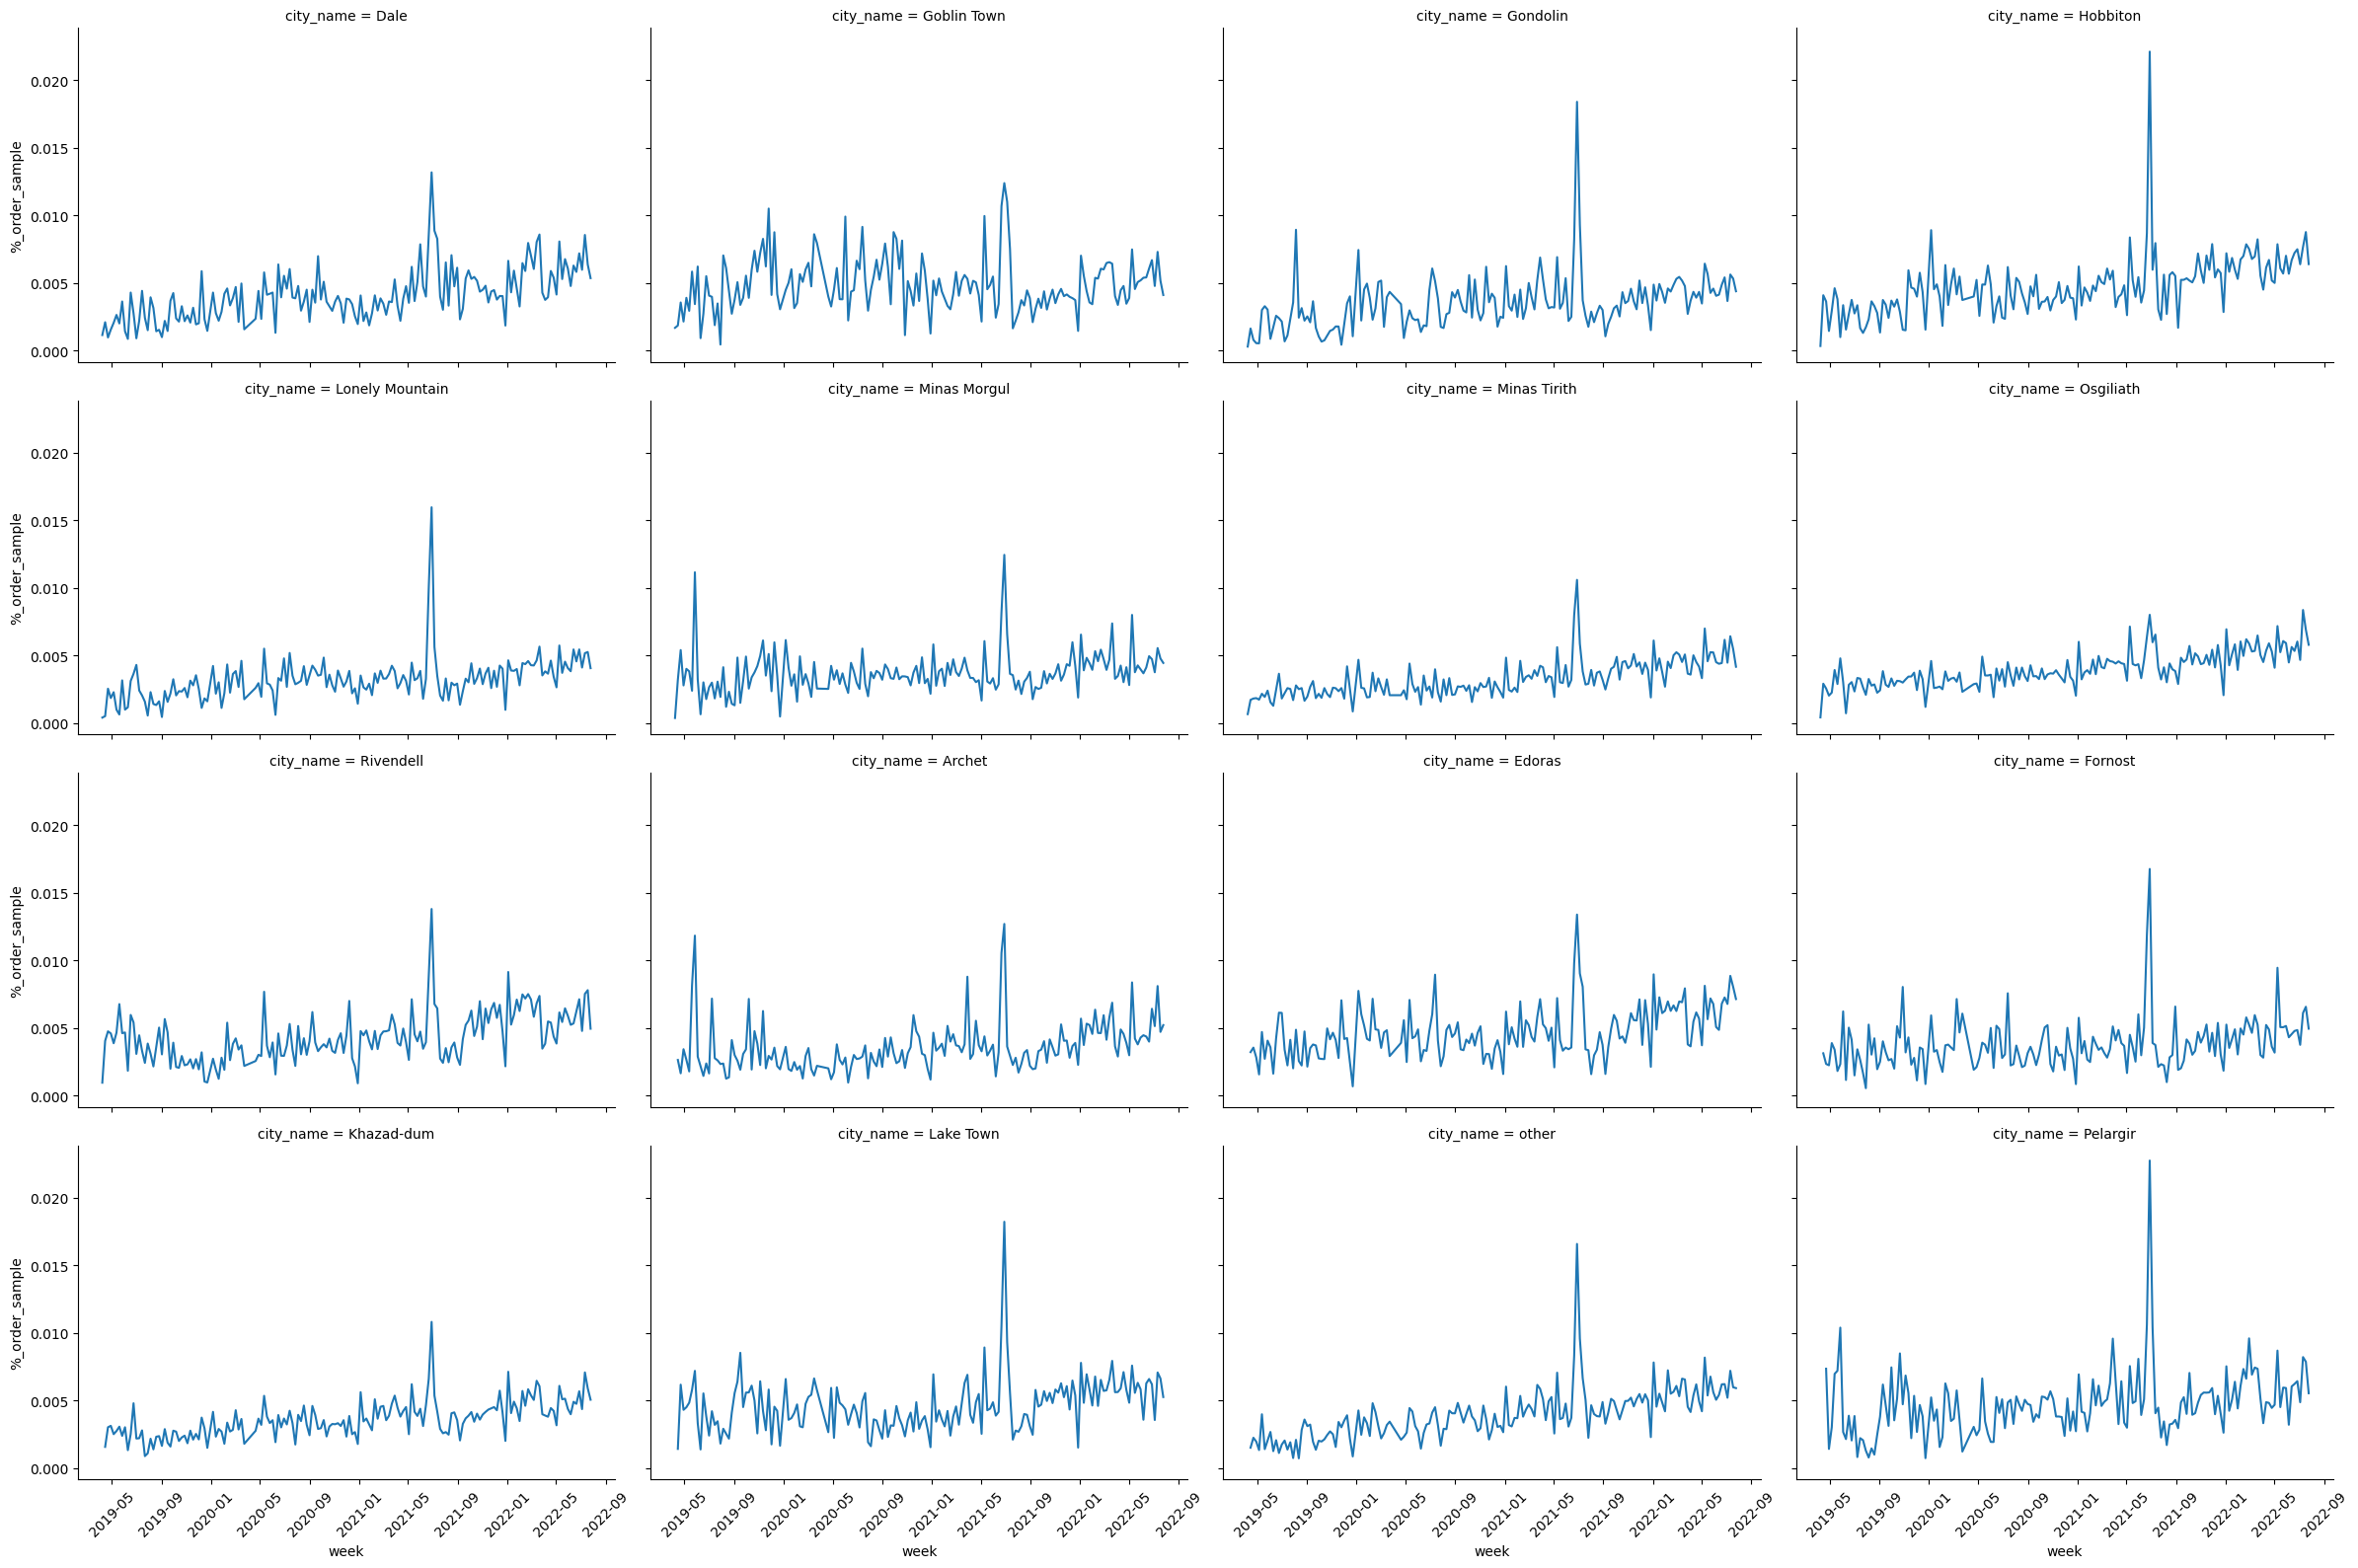

In [10]:
# Investigating the city level sample differences in a FacetGrid
g = sns.FacetGrid(combined_data, col="city_name", col_wrap=4, height=4, aspect=1.5)
g.map(sns.lineplot, "week", "%_order_sample")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

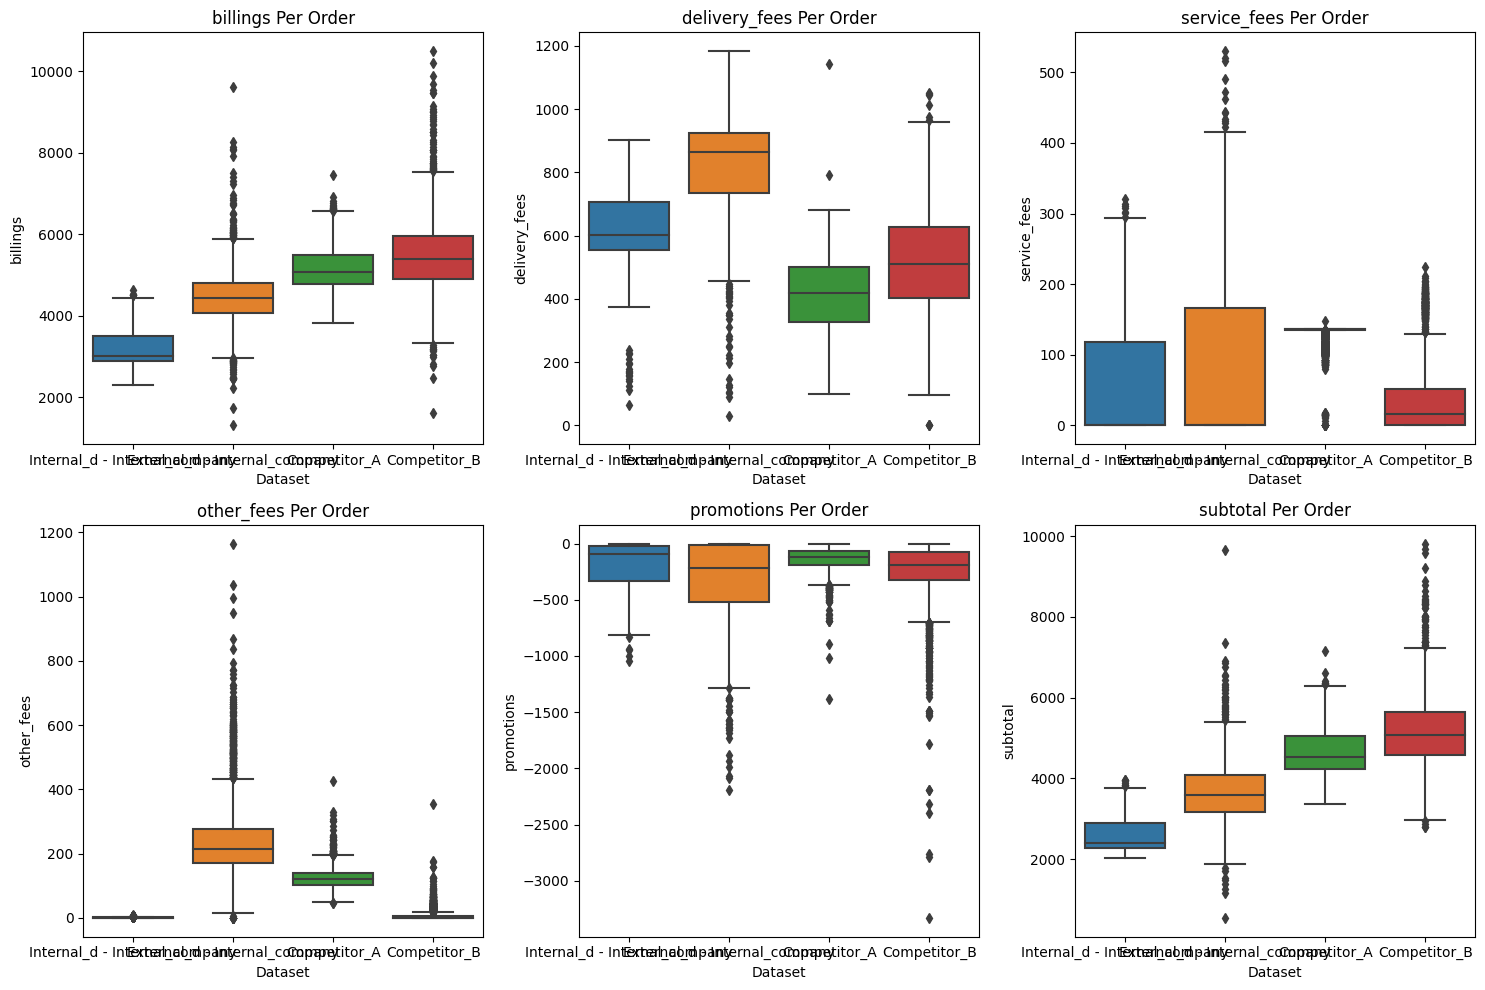

In [11]:
# Calculating the average of each component per order for both datasets
internal_data_per_order = internal_data.copy()
internal_data_per_order['competitor'] = 'Internal_org'
external_data_weekly_per_order = external_data_weekly.copy()
external_Internal_org_per_order = external_Internal_org.copy()
external_Competitor_A_per_order = external_Competitor_A.copy()
external_Competitor_B_per_order = external_Competitor_B.copy()
# Dividing each component by the number of orders for each row in all datasets
components = ['billings', 'delivery_fees', 'service_fees', 'other_fees', 'promotions', 'subtotal']
for component in components:
    internal_data_per_order[component] /= internal_data_per_order['orders']
    external_Internal_org_per_order[component] /= external_Internal_org_per_order['orders']
    external_Competitor_A_per_order[component] /= external_Competitor_A['orders']
    external_Competitor_B_per_order[component] /= external_Competitor_B['orders']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Creating boxplots for each component
for i, component in enumerate(components):
    # Creating a combined dataset for plotting
    combined_data = pd.concat([
        internal_data_per_order[[component]].assign(Dataset='Internal_d - Internal_company'),
        external_Internal_org_per_order[[component]].assign(Dataset='External_d - Internal_company'),
        external_Competitor_A_per_order[[component]].assign(Dataset='Competitor_A'),
        external_Competitor_B_per_order[[component]].assign(Dataset='Competitor_B')
    ])
    sns.boxplot(x='Dataset', y=component, data=combined_data, ax=axes[i])
    axes[i].set_title(f'{component} Per Order')
# Adjusting layout
plt.tight_layout()
plt.show()

## Adjusting the bias based on aligning the internal and external data distributions

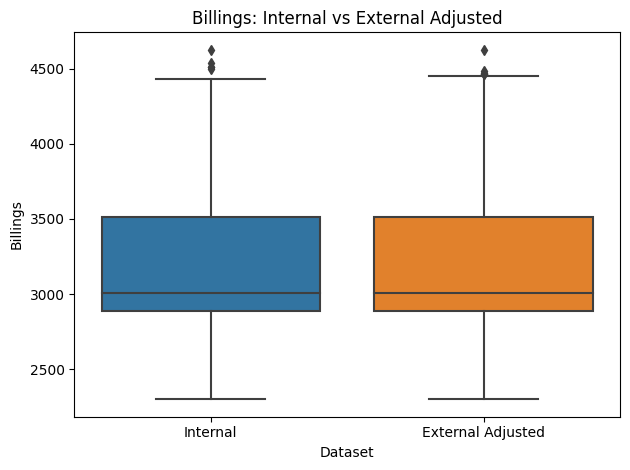

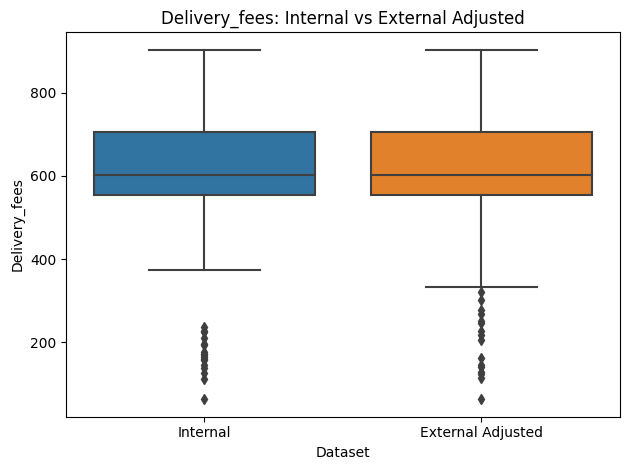

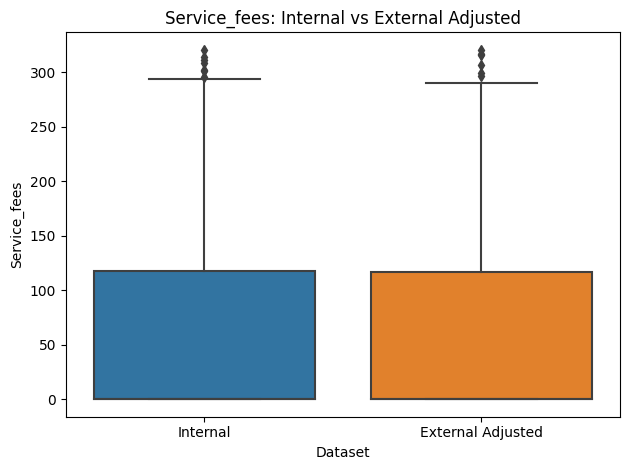

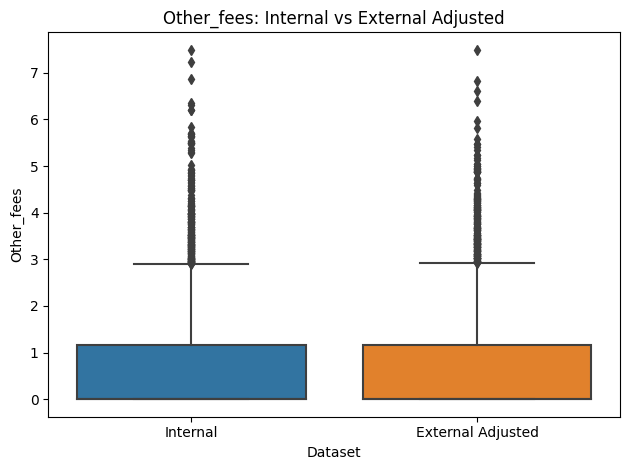

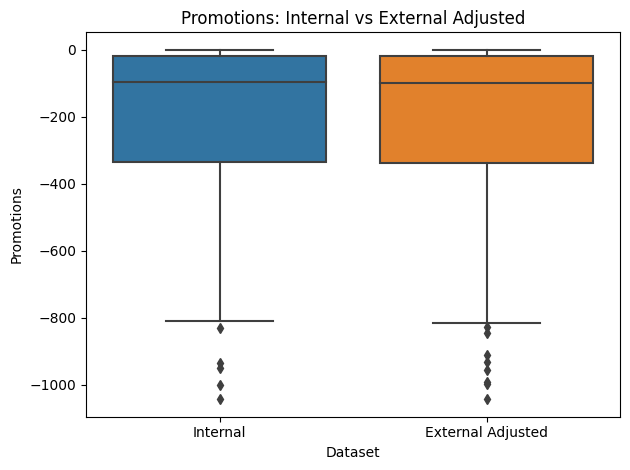

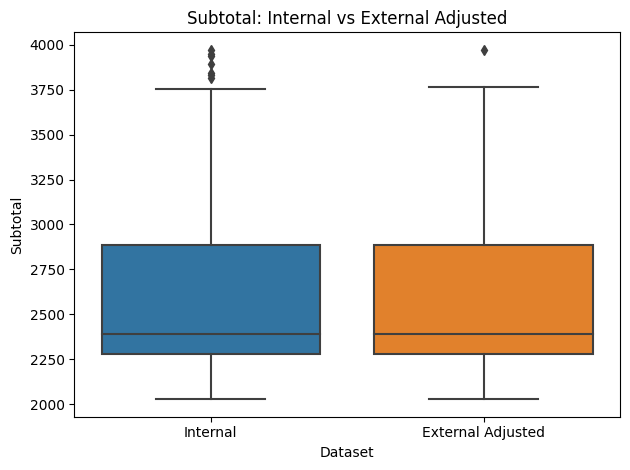

In [13]:
def qq_align(source_data, target_data, num_quantiles=100):
    """
    Align the quantiles of source data to match those of target data.
    """
    # Define quantiles
    quantiles = np.linspace(0, 1, num_quantiles)
    # Calculate quantiles for both datasets
    source_quantiles = np.quantile(source_data, quantiles)
    target_quantiles = np.quantile(target_data, quantiles)
    # Interpolation for source data
    aligned_data = np.interp(source_data, source_quantiles, target_quantiles)
    return aligned_data

for component in components:
    # Apply Quantile Alignment
    adjusted_component = qq_align(
        external_Internal_org_per_order[component],
        internal_data_per_order[component]
    )
    # Add the adjusted data to the external dataset
    external_Internal_org_per_order[f'adjusted_{component}'] = adjusted_component

    # Combine the internal and adjusted external data for plotting
    combined_data = pd.concat([
        internal_data_per_order[[component]].assign(Dataset='Internal'),
        external_Internal_org_per_order[[f'adjusted_{component}']].rename(columns={f'adjusted_{component}': component}).assign(Dataset='External Adjusted')
    ])
    # Create the boxplot for the current component
    sns.boxplot(x='Dataset', y=component, data=combined_data)
    plt.title(f'{component.capitalize()}: Internal vs External Adjusted')
    plt.xlabel('Dataset')
    plt.ylabel(component.capitalize())
    plt.tight_layout()
    plt.show()


## Adjusting the distrubtions of Competitor_B and Competitor_A with the same ratios

In [14]:
def calculate_adjustment_ratios(original_data, adjusted_data, num_quantiles=100):
    """
    Calculate the adjustment ratios for each quantile.
    """
    quantiles = np.linspace(0, 1, num_quantiles)
    original_quantiles = np.quantile(original_data, quantiles)
    adjusted_quantiles = np.quantile(adjusted_data, quantiles)
    # Calculate adjustment ratios
    adjustment_ratios = adjusted_quantiles / original_quantiles
    return adjustment_ratios

def apply_adjustment_ratios(data, adjustment_ratios, num_quantiles=100):
    """
    Apply the adjustment ratios to the data.
    """
    quantiles = np.linspace(0, 1, num_quantiles)
    data_quantiles = np.quantile(data, quantiles)
    # Interpolate to apply the ratios
    adjusted_data = np.interp(data, data_quantiles, data_quantiles * adjustment_ratios)
    return adjusted_data

components = ['billings', 'delivery_fees', 'service_fees', 'other_fees', 'promotions', 'subtotal']

for component in components:
    # Calculate adjustment ratios for Internal_org data
    adjustment_ratios = calculate_adjustment_ratios(
        external_Internal_org_per_order[component],
        external_Internal_org_per_order[f'adjusted_{component}']
    )

    # Apply adjustment ratios to Competitor_A and Competitor_B data
    external_Competitor_A_per_order[f'adjusted_{component}'] = apply_adjustment_ratios(
        external_Competitor_A_per_order[component], adjustment_ratios
    )
    external_Competitor_B_per_order[f'adjusted_{component}'] = apply_adjustment_ratios(
        external_Competitor_B_per_order[component], adjustment_ratios
    )


/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3878952436.py:9: RuntimeWarning: divide by zero encountered in true_divide
  adjustment_ratios = adjusted_quantiles / original_quantiles
/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3878952436.py:19: RuntimeWarning: invalid value encountered in multiply
  adjusted_data = np.interp(data, data_quantiles, data_quantiles * adjustment_ratios)
/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3878952436.py:19: RuntimeWarning: invalid value encountered in multiply
  adjusted_data = np.interp(data, data_quantiles, data_quantiles * adjustment_ratios)
/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3878952436.py:9: RuntimeWarning: invalid value encountered in true_divide
  adjustment_ratios = adjusted_quantiles / original_quantiles
/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3878952436.py:9: RuntimeWarning: divide by zero encountered in true_divide
  adjustmen

## Checking if adjustments are done as expected

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


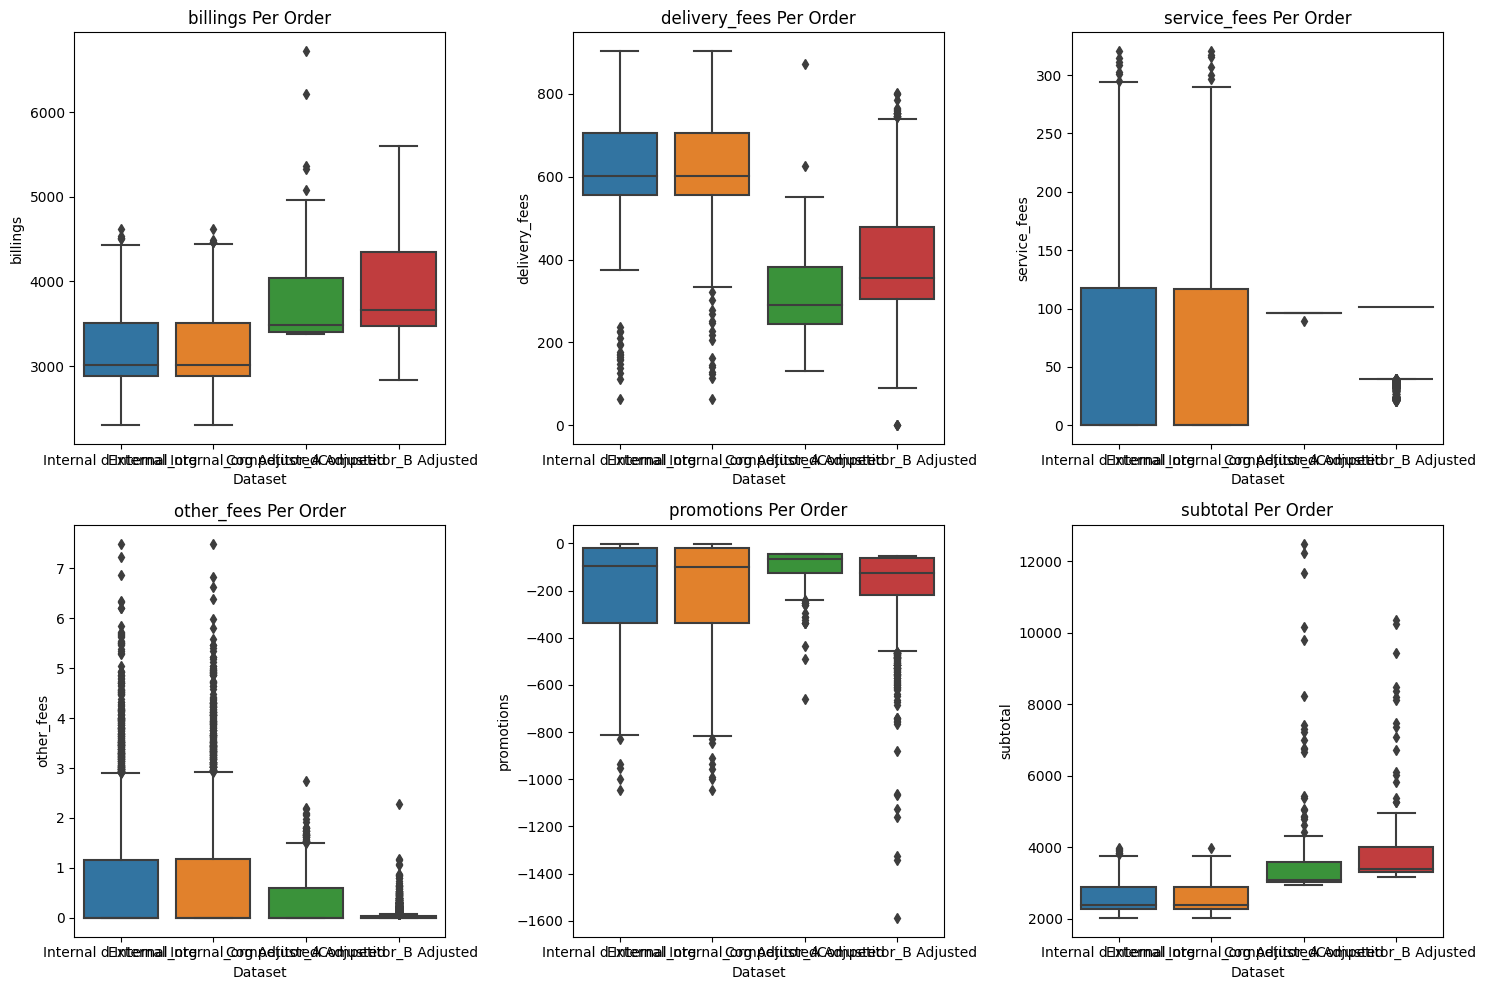

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
# Creating boxplots for each component comparing internal data with adjusted data for each competitor
for i, component in enumerate(components):
    # Creating a combined dataset for plotting
    combined_data = pd.concat([
        internal_data_per_order[[component]].rename(columns={f'adjusted_{component}': component}).assign(Dataset='Internal d Internal_org'),
        external_Internal_org_per_order[[f'adjusted_{component}']].rename(columns={f'adjusted_{component}': component}).assign(Dataset='External Internal_org Adjusted'),
        external_Competitor_A_per_order[[f'adjusted_{component}']].rename(columns={f'adjusted_{component}': component}).assign(Dataset='Competitor_A Adjusted'),
        external_Competitor_B_per_order[[f'adjusted_{component}']].rename(columns={f'adjusted_{component}': component}).assign(Dataset='Competitor_B Adjusted')
    ])
    sns.boxplot(x='Dataset', y=component, data=combined_data, ax=axes[i])
    axes[i].set_title(f'{component} Per Order')
# Adjusting layout
plt.tight_layout()
plt.show()

# Part 2: Modeling Market Positioning

## Pre-processing the rebased external dataset 

In [20]:
external_Internal_org_per_order['competitor'] = 'Internal_org'
external_Competitor_A_per_order['competitor'] = 'Competitor_A'
external_Competitor_B_per_order['competitor'] = 'Competitor_B'

rebased_external_database_weekly_per_order = pd.concat([external_Internal_org_per_order,
                                                        external_Competitor_A_per_order, 
                                                        external_Competitor_B_per_order])

# Select the relevant columns and include the 'competitor' column
rebased_external_database_weekly_per_order = rebased_external_database_weekly_per_order[['competitor', 
                                                                                         'city_name', 
                                                                                         'week', 
                                                                                         'orders', 
                                                                                         'adjusted_billings', 
                                                                                         'adjusted_delivery_fees', 
                                                                                         'adjusted_service_fees', 
                                                                                         'adjusted_other_fees', 
                                                                                         'adjusted_promotions', 
                                                                                         'adjusted_subtotal']]
# Replace NaN and inf values with 0
rebased_external_database_weekly_per_order['adjusted_service_fees'] = rebased_external_database_weekly_per_order['adjusted_service_fees'].replace([np.inf, -np.inf, np.nan], 0)
rebased_external_database_weekly_per_order['adjusted_promotions'] = rebased_external_database_weekly_per_order['adjusted_promotions'].replace([np.inf, -np.inf, np.nan], 0)

## Converting per orders estimates to total number per week for a given city based on the sample sizes

In [21]:


internal_data_adjusted = internal_data_per_order.rename(columns={'billings': 'adjusted_billings',
                                                        'delivery_fees': 'adjusted_delivery_fees', 
                                                       'service_fees':'adjusted_service_fees',
                                                       'other_fees':'adjusted_other_fees',
                                                      'promotions':'adjusted_promotions',
                                                      'subtotal':'adjusted_subtotal'})
internal_data_adjusted['competitor'] = 'SOT_Internal_org'
internal_data_adjusted = internal_data_adjusted.drop(['billings_per_order','promotions_per_order'],axis=1)

total_dataset = rebased_external_database_weekly_per_order.append(internal_data_adjusted)                                          
# Calculate sample size for Internal_org orders by dividing 'Internal_org' orders by 'SOT_Internal_org' orders per city.
Internal_org_data = total_dataset[total_dataset['competitor'] == 'Internal_org']
sot_Internal_org_data = total_dataset[total_dataset['competitor'] == 'SOT_Internal_org']

# Merge both dataframes on city and week to align the data
merged_data = pd.merge(Internal_org_data, sot_Internal_org_data, on=['city_name', 'week'], suffixes=('_ue', '_sot'))
merged_data['sample_size'] = merged_data['orders_ue'] / merged_data['orders_sot']
merged_data = merged_data[['competitor_ue', 'city_name', 'week', 'orders_ue', 'orders_sot', 'sample_size']]
city_week_sample_size = merged_data[['city_name', 'week', 'sample_size']].drop_duplicates()
# Merge this sample size data with the total dataset to apply the sample size to each competitor
total_dataset = pd.merge(total_dataset, city_week_sample_size, on=['city_name', 'week'], how='left')
total_dataset.rename(columns={'sample_size': 'sample_size_per_city_week'}, inplace=True)
total_dataset = total_dataset[total_dataset['competitor'] != 'SOT_Internal_org']
total_dataset['orders'] = total_dataset['orders'] / total_dataset['sample_size_per_city_week'] 

columns_to_multiply_by_orders = ['adjusted_billings','adjusted_delivery_fees', 'adjusted_service_fees', 'adjusted_other_fees', 
                       'adjusted_promotions', 'adjusted_subtotal']
for column in columns_to_multiply_by_orders:
    total_dataset[column] *= total_dataset['orders']


/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3555822284.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_dataset = rebased_external_database_weekly_per_order.append(internal_data_adjusted)


## Aggregarting the final dataset to YoY change data so trends can be investigated.
### Investigations of this data can be found in this sheet: https://docs.google.com/spreadsheets/d/1WhTLUg8AsLHK42G_qe-RfFcK-iq4Fpp8hSgwcC7xm6I/edit#gid=0

In [22]:
# Step 1: Find the maximum week in the dataset
max_week = total_dataset['week'].max()
# Step 2: Calculate the minimum week by going back 52 weeks from the maximum week
min_week = max_week - pd.DateOffset(weeks=52)
def categorize_year(week):
    """Function to categorize weeks into years based on the defined 52-week periods
     and Iterate backwards from the maximum week, categorizing each 52-week period into a year""" 
    current_max_week = max_week
    while current_max_week >= min_week:
        if week <= current_max_week and week > (current_max_week - pd.DateOffset(weeks=52)):
            return current_max_week.year
        current_max_week -= pd.DateOffset(weeks=52)
    return week.year  

# Apply the function to categorize each week into a year
total_dataset['categorized_year'] = total_dataset['week'].apply(categorize_year)

# Group by the new 'categorized_year' column along with 'city_name' and 'competitor'
yearly_to_year_data = total_dataset.groupby(['categorized_year', 'city_name', 'competitor']).sum().reset_index()

/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/3191025631.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_to_year_data = total_dataset.groupby(['categorized_year', 'city_name', 'competitor']).sum().reset_index()


In [23]:
"Creating a Tier based dataset for potential plots"

city_categories = {
    "Osgiliath": "Large cities",
    "Khazad-dum": "Large cities",
    "Minas Tirith": "Large cities",
    "Hobbiton": "Long Tail",
    "Rivendell": "Long Tail",
    "Lonely Mountain": "Long Tail",
    "Gondolin": "Long Tail",
    "Edoras": "Long Tail",
    "Dale": "Long Tail",
    "Minas Morgul": "Long Tail",
    "Lake Town": "Long Tail",
    "Goblin Town": "Long Tail",
    "Pelargir": "Long Tail",
    "Fornost": "Long Tail",
    "Archet": "Long Tail",
    # Default category for other cities
    "other": "Long Tail"
}

# Add a new column for city category
total_dataset['Tier'] = total_dataset['city_name'].map(city_categories)
total_dataset['total_fees'] = total_dataset['adjusted_service_fees'] + total_dataset['adjusted_other_fees'] + total_dataset['adjusted_delivery_fees']

# # Aggregate data per week and city category
weekly_aggregated_data_tier = total_dataset.groupby(['week', 'Tier', 'competitor']).sum().reset_index()

/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/395428462.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_aggregated_data_tier = total_dataset.groupby(['week', 'Tier', 'competitor']).sum().reset_index()


## Visually Modeling the market historical weekly sales, orders and market position

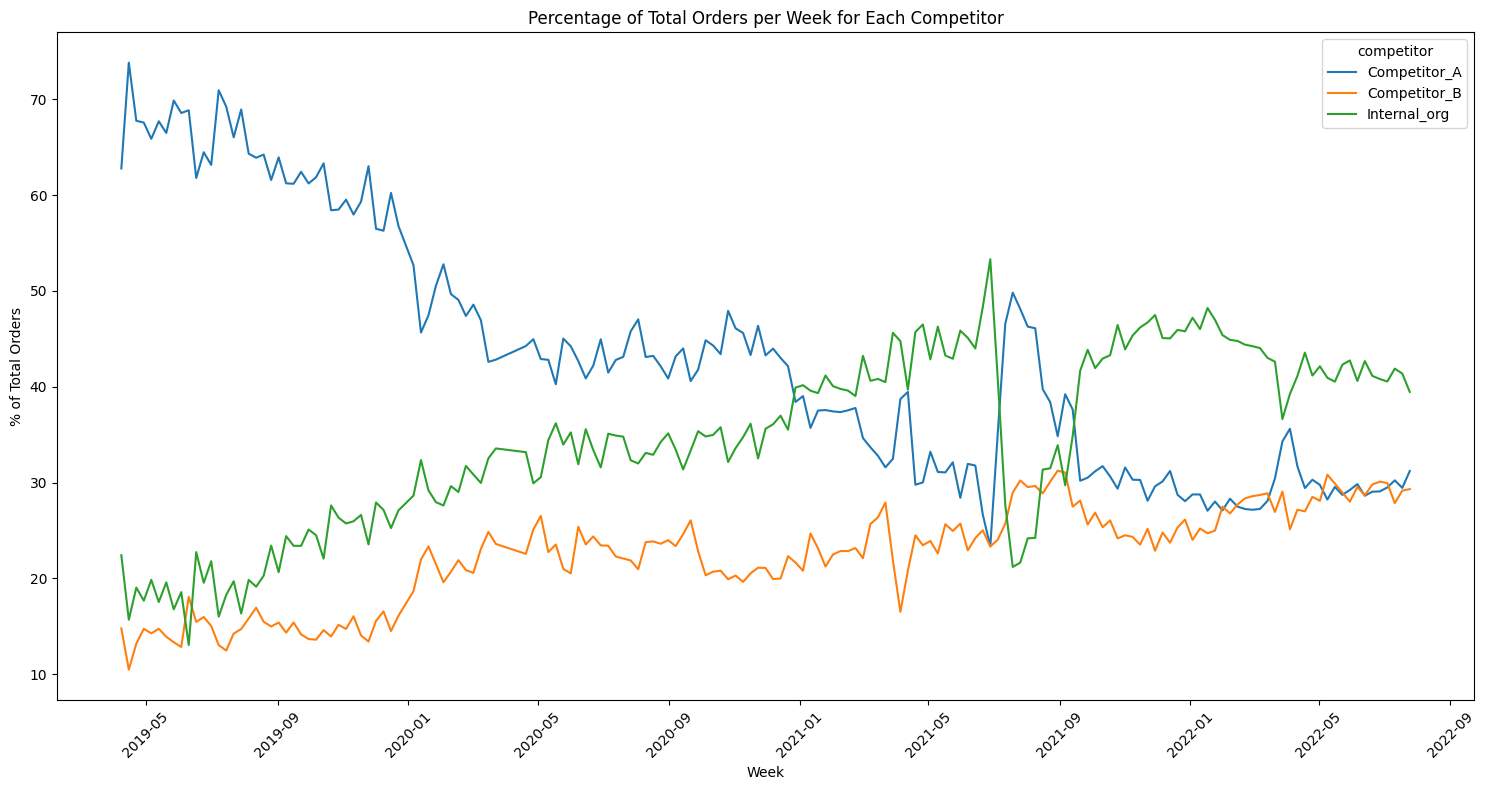

In [24]:
# Filter dataset to include only the three competitors
competitors = ['Internal_org', 'Competitor_A', 'Competitor_B']
filtered_dataset = total_dataset[total_dataset['competitor'].isin(competitors)]
# Group by week and competitor, summing the orders
grouped_data = filtered_dataset.groupby(['week', 'competitor'])['orders'].sum().reset_index()
# Calculate the total orders per week
total_orders_per_week = grouped_data.groupby('week')['orders'].sum().reset_index()
# Merge to get the total orders per week in the grouped_data
grouped_data = grouped_data.merge(total_orders_per_week, on='week', suffixes=('', '_total'))
grouped_data['percent_of_total_orders'] = (grouped_data['orders'] / grouped_data['orders_total']) * 100
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped_data, x='week', y='percent_of_total_orders', hue='competitor')
plt.xticks(rotation=45)
plt.xlabel('Week')
plt.ylabel('% of Total Orders')
plt.title('Percentage of Total Orders per Week for Each Competitor')
plt.tight_layout()

plt.show()

In [25]:
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

pio.renderers.default = 'notebook'
fig = go.Figure()
for competitor in grouped_data['competitor'].unique():
    competitor_data = grouped_data[grouped_data['competitor'] == competitor]
    fig.add_trace(go.Scatter(
        x=competitor_data['week'],
        y=competitor_data['percent_of_total_orders'],
        mode='lines',
        name=competitor
    ))
fig.update_layout(
    title='Percentage of Total Orders per Week for Each Competitor',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Percentage of Total Orders')
)
fig.show()

In [26]:
weekly_promotion_sum = total_dataset.groupby('week')['adjusted_promotions'].sum().reset_index()
fig_promotion = go.Figure()
fig_promotion.add_trace(go.Scatter(
    x=weekly_promotion_sum['week'],
    y=weekly_promotion_sum['adjusted_promotions'],
    mode='lines', 
    name='Promotions'
))
fig_promotion.update_layout(
    title='Sum of Adjusted Promotions per Week',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Sum of Adjusted Promotions')
)
fig_promotion.show()

In [27]:
grouped_data['week'] = pd.to_datetime(grouped_data['week'])
pivot_data = grouped_data.pivot(index='week', columns='competitor', values='percent_of_total_orders')
pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
fig = go.Figure()
for competitor in pivot_data.columns:
    fig.add_trace(go.Scatter(
        x=pivot_data.index,
        y=pivot_data[competitor],
        mode='lines',
        name=competitor,
        stackgroup='one', 
    ))
fig.update_layout(
    title='100% Stacked Area Chart of Total Orders per Week for Each Competitor',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Percentage of Total Orders', tickformat=',.%'),
    showlegend=True
)
fig.show()

In [28]:
total_dataset['week'] = pd.to_datetime(total_dataset['week'])
weekly_sum_data = total_dataset.groupby(['week', 'competitor'])[['adjusted_billings','adjusted_promotions','adjusted_subtotal','total_fees']].sum().reset_index()
fig = go.Figure()
for competitor in weekly_sum_data['competitor'].unique():
    competitor_data = weekly_sum_data[weekly_sum_data['competitor'] == competitor]
    fig.add_trace(go.Scatter(
        x=competitor_data['week'],
        y=competitor_data['adjusted_billings'],
        mode='lines',  
        name=competitor
    ))
fig.update_layout(
    title='Sum of Adjusted Billings per Week for Each Competitor',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Sum of Adjusted Billings')
)
fig.show()

In [29]:
weekly_promo_data = total_dataset.groupby(['week', 'competitor'])['adjusted_promotions'].sum().reset_index()
promo_fig = go.Figure()
for competitor in weekly_promo_data['competitor'].unique():
    competitor_data = weekly_promo_data[weekly_promo_data['competitor'] == competitor]
    promo_fig.add_trace(go.Scatter(
        x=competitor_data['week'],
        y=competitor_data['adjusted_promotions'],
        mode='lines',
        name=competitor
    ))

promo_fig.update_layout(
    title='Sum of Adjusted Promotions per Week for Each Competitor',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Sum of Adjusted Promotions')
)

# promo_fig.show()

In [30]:
summed_data = total_dataset.groupby(['week', 'competitor']).sum().reset_index()
columns_to_convert = ['adjusted_billings', 'adjusted_delivery_fees', 'adjusted_service_fees',
                      'adjusted_other_fees', 'adjusted_promotions', 'adjusted_subtotal', 'total_fees']
total_dataset_per_order = summed_data.copy()
for col in columns_to_convert:
    total_dataset_per_order[col] = total_dataset_per_order[col] / total_dataset_per_order['orders']


# Group by 'week' and 'competitor' and calculate the sum of adjusted promotions and total fees per order
weekly_fee_promo_data = total_dataset_per_order.copy()

# Creating a figure for Total Fees per Order
fee_fig = go.Figure()


# Adding a trace for each competitor for Total Fees
for competitor in weekly_fee_promo_data['competitor'].unique():
    competitor_data = weekly_fee_promo_data[weekly_fee_promo_data['competitor'] == competitor]
    fee_fig.add_trace(go.Scatter(
        x=competitor_data['week'],
        y=competitor_data['total_fees'],
        mode='lines',
        name=competitor
    ))

# Adding range selector buttons to Total Fees figure
fee_fig.update_layout(
    title='Total Fees per Order per Week for Each Competitor',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Total Fees per Order')
)

# Creating a figure for Adjusted Promotions per Order
promo_fig = go.Figure()

# Adding a trace for each competitor for Adjusted Promotions
for competitor in weekly_fee_promo_data['competitor'].unique():
    competitor_data = weekly_fee_promo_data[weekly_fee_promo_data['competitor'] == competitor]
    promo_fig.add_trace(go.Scatter(
        x=competitor_data['week'],
        y=competitor_data['adjusted_promotions'],
        mode='lines',
        name=competitor
    ))

# Adding range selector buttons to Adjusted Promotions figure
promo_fig.update_layout(
    title='Sum of Adjusted Promotions per Order per Week for Each Competitor',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Sum of Adjusted Promotions per Order')
)

# Showing the figures
fee_fig.show()
promo_fig.show()


subtotal_fig = go.Figure()
for competitor in weekly_fee_promo_data['competitor'].unique():
    competitor_data = weekly_fee_promo_data[weekly_fee_promo_data['competitor'] == competitor]
    subtotal_fig.add_trace(go.Scatter(
        x=competitor_data['week'],
        y=competitor_data['adjusted_subtotal'],
        mode='lines',
        name=competitor
    ))
subtotal_fig.update_layout(
    title='Sum of Adjusted Subtotal Earnings per Order per Week for Each Competitor',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Sum of Subtotal Per Order')
)

/var/folders/2d/c0r3z7dj36g3j2fc756dv8zc0000gn/T/ipykernel_33050/2961277813.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

